In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Lettura dei dati e creazione dei dataframe per i giocatori, i tornei e i match ATP dal 1968 al 2024 
atp_matches = pd.read_csv('Data/atpdata/atp_matches.csv')
atp_players = pd.read_csv('Data/atpdata/atp_players.csv')
atp_rankings = pd.read_csv('Data/atpdata/atp_rankings.csv', low_memory=False);

#Pallet di colori per i grafici
colors = ['#11565c', '#007660', '#459146', '#9aa414', '#ffa600' ]

## Panoramica sugli attributi dei giocatori

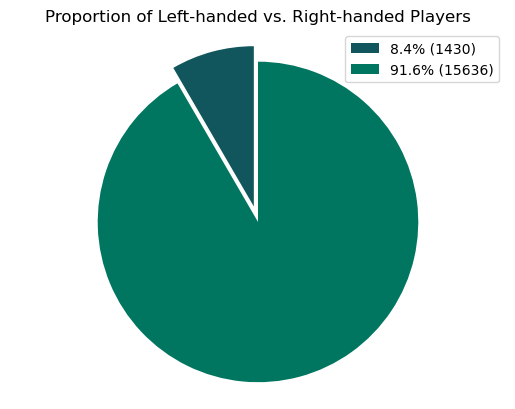

In [3]:
# Numero di giocatori che usanto la mano destra e sinistra
left_handed_count = atp_players['hand'].value_counts()['L']
right_handed_count = atp_players['hand'].value_counts()['R']

hand_counts = pd.DataFrame({'Count': [left_handed_count, right_handed_count]}, index=['Left-handed', 'Right-handed'])

explode = (0.1, 0)

fig, ax = plt.subplots()
ax.pie(hand_counts['Count'], labels=None, colors=colors, explode=explode, startangle=90)
ax.axis('equal')
ax.set_title('Proportion of Left-handed vs. Right-handed Players')

total_count = hand_counts['Count'].sum()
percentages = hand_counts['Count'] / total_count * 100
labels = [f'{p:.1f}% ({c})' for p, c in zip(percentages, hand_counts['Count'])]
ax.legend(labels, loc='best')

plt.show()


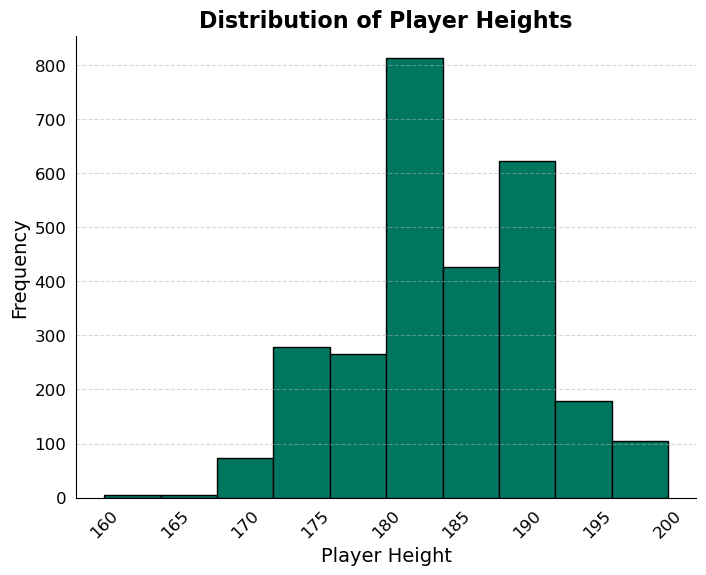

In [4]:
# Distributione dell'altezza dei giocatori
plt.figure(figsize=(8, 6))

filtered_heights = atp_players[atp_players['height'] >= 160]['height']

plt.hist(filtered_heights, bins=10, range=(160, 200), color=colors[1], edgecolor='black', align='mid')

plt.xlabel('Player Height', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Player Heights', fontsize=16, fontweight='bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tick_params(axis='both', which='both', bottom=False, left=False, labelsize=12)

plt.xticks(rotation=45)

plt.show()


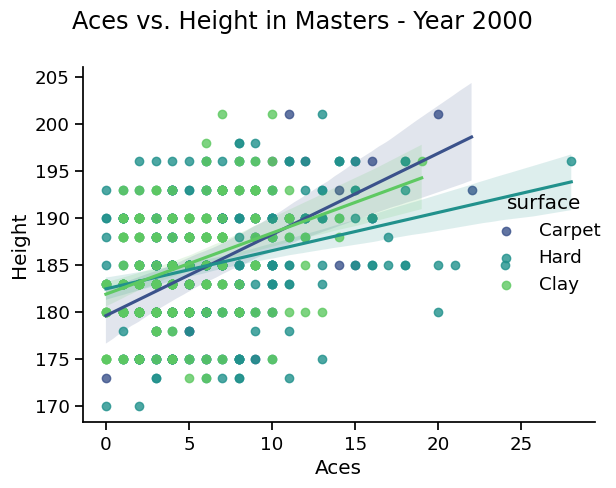

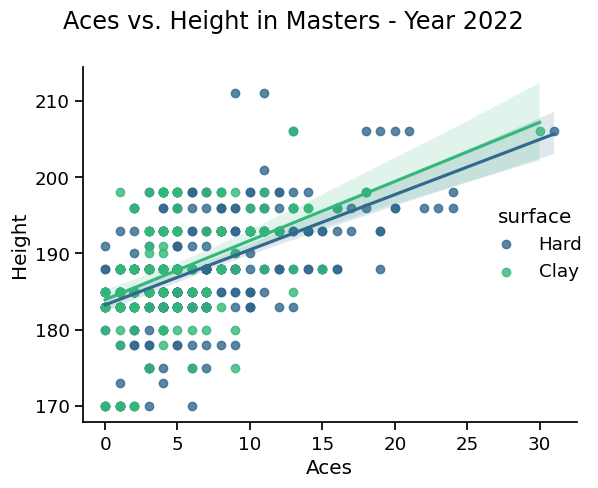

In [5]:
#Confroti tra altezza e numero di ace per i tornei di tipo Masters nel 2000 e nel 2018
atp_matches['tourney_yearmonth'] = atp_matches.tourney_date.astype(str).str[:6]
atp_matches['tourney_year'] = atp_matches.tourney_date.astype(str).str[:4]
atp_matches['tourney_year'] = atp_matches['tourney_year'].astype(int)

with sns.plotting_context("notebook", font_scale=1.2):
    g1 = sns.lmplot(x='w_ace', y='winner_ht', hue='surface', fit_reg=True, data=atp_matches[(atp_matches['tourney_level'].isin(['M']))&(atp_matches['tourney_year']==2000)], palette='viridis')
    g1.fig.suptitle('Aces vs. Height in Masters - Year 2000') 
    g1.set(xlabel='Aces', ylabel='Height')
    g1.fig.tight_layout()

    g2 = sns.lmplot(x='w_ace', y='winner_ht', hue='surface', fit_reg=True, data=atp_matches[(atp_matches['tourney_level'].isin(['M']))&(atp_matches['tourney_year']==2022)], palette='viridis')
    g2.fig.suptitle('Aces vs. Height in Masters - Year 2022')
    g2.set(xlabel='Aces', ylabel='Height')
    g2.fig.tight_layout()


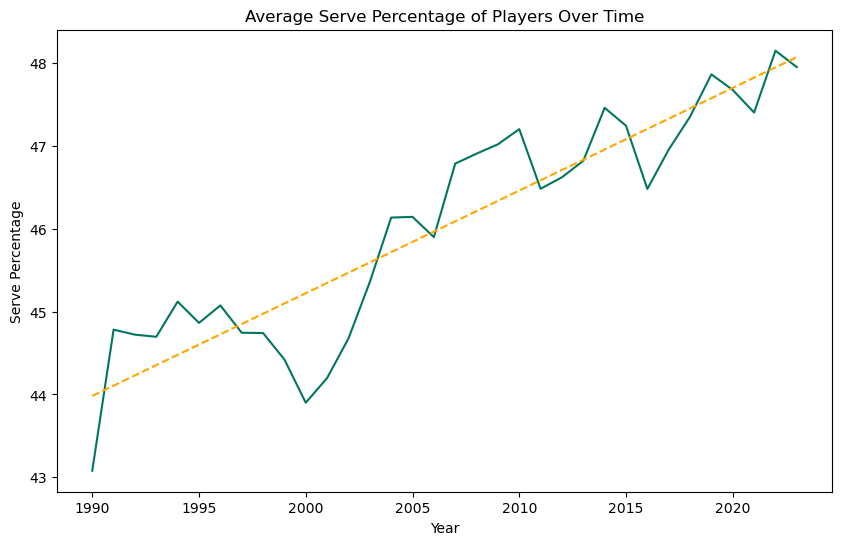

In [6]:
serve_percentage = atp_matches.groupby('tourney_year')['w_1stWon'].sum() / atp_matches.groupby('tourney_year')['w_svpt'].sum() * 100
serve_percentage.plot(kind='line', figsize=(10, 6), color=colors[1])
plt.xlabel('Year')
plt.ylabel('Serve Percentage')
plt.title('Average Serve Percentage of Players Over Time')

x = serve_percentage.index.values
y = serve_percentage.values
coefficients = np.polyfit(x, y, 1)
trend_line = np.poly1d(coefficients)

plt.plot(x, trend_line(x), color=colors[4], linestyle='--')

plt.show()


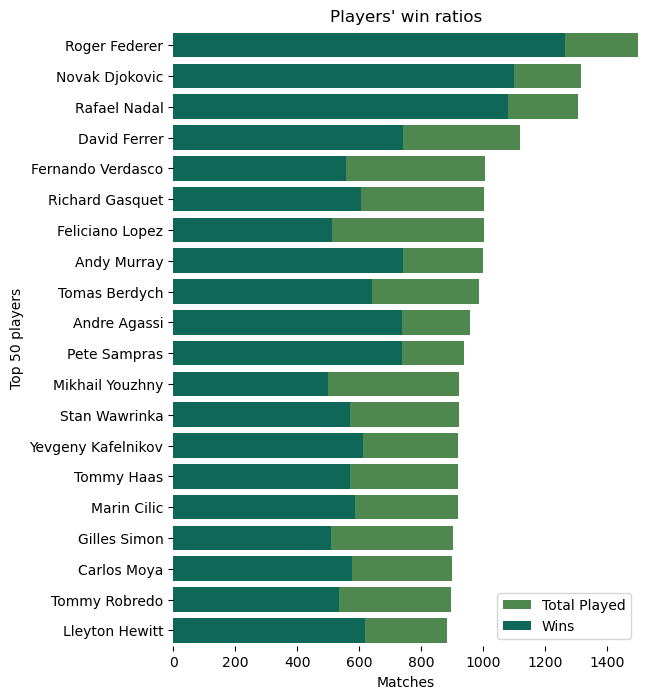

In [7]:
#Win ratio dei giocatori
df_win_players = atp_matches.groupby(['winner_name']).agg({'tourney_id':'count','tourney_year':'max'}).reset_index()[['winner_name','tourney_id','tourney_year']]
df_win_players.columns = ['player_name','total_won','tourney_year']
df_win_players['year_period'] = pd.cut(df_win_players.tourney_year.astype(int), [1968, 1979, 1989, 1999, 2009, np.inf], labels=['1970s','1980s','1990s','2000s','2010s'])

df_lost_players = atp_matches.groupby(['loser_name']).agg({'tourney_id':'count','tourney_year':'max'}).reset_index()[['loser_name','tourney_id','tourney_year']]
df_lost_players.columns = ['player_name','total_lost','tourney_year']
df_lost_players['year_period'] = pd.cut(df_lost_players.tourney_year.astype(int), [1968, 1979, 1989, 1999, 2009, np.inf], labels=['1970s','1980s','1990s','2000s', '2010s'])


dfs_players = (df_win_players, df_lost_players)
dfs_players_concat = pd.concat(dfs_players, sort=False)


dfs_players_final = dfs_players_concat.groupby(['player_name','year_period']).agg({'total_won':'sum','total_lost':'sum'}).fillna(0).reset_index()

dfs_players_final['total_played'] = dfs_players_final['total_won']+dfs_players_final['total_lost']
dfs_players_final['win_ratio'] = dfs_players_final['total_won']/(dfs_players_final['total_won']+dfs_players_final['total_lost'])

dfs_players_top = dfs_players_final.sort_values(['total_played'],ascending=False).head(20)

f, ax = plt.subplots(figsize=(6, 8))

sns.set_color_codes("pastel")
sns.barplot(x="total_played", y="player_name", data=dfs_players_top, label="Total Played", color=colors[2])

sns.set_color_codes("muted")
sns.barplot(x="total_won", y="player_name", data=dfs_players_top, label="Wins", color=colors[1])

ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlim=(0, 1500), ylabel="Top 50 players",
       xlabel="Matches", title="Players' win ratios")
sns.despine(left=True, bottom=True)